In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()

In [3]:
# Load Real Market Data
data = pd.read_csv('../data/cleaned_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

In [4]:
selected_assets = ['AMZN','MMM','COF','FSLR','ANF',
                   'BG','CCL','DHI','CTSH','DXC']

data = data[selected_assets].abs()

In [5]:
data.head()

,AMZN,MMM,COF,FSLR,ANF,BG,CCL,DHI,CTSH,DXC
Date,,,,,,,,,,
2022-07-18,113.76,128.91,110.49,67005.00,16.86,87.71,9.65,72.57,65.10,29.01
2022-07-19,118.21,132.13,113.02,70.65,17.89,90.00,10.36,74.28,67.42,30.79
2022-07-20,122.77,133.01,114.76,72.98,18.51,91.89,11.09,73.08,68.12,30.80
2022-07-21,124.63,133.95,114.27,73.26,18.67,91.59,9.85,75.83,68.98,31.27
2022-07-22,122.42,134.12,108.93,72.59,18.57,91.02,9.26,77.39,69.10,31.00


In [6]:
returns = data.pct_change()
returns = returns.iloc[1:]               # Deletes the first row that has no daily return
returns = returns.dropna(axis='columns') # Filter out stocks with NaNs

returns.head()

,AMZN,MMM,COF,FSLR,ANF,BG,CCL,DHI,CTSH,DXC
Date,,,,,,,,,,
2022-07-19,0.039117,0.024979,0.022898,-0.998946,0.061091,0.026109,0.073575,0.023563,0.035637,0.061358
2022-07-20,0.038575,0.006660,0.015396,0.032979,0.034656,0.021000,0.070463,-0.016155,0.010383,0.000325
2022-07-21,0.015150,0.007067,-0.004270,0.003837,0.008644,-0.003265,-0.111812,0.037630,0.012625,0.015260
2022-07-22,-0.017732,0.001269,-0.046731,-0.009146,-0.005356,-0.006223,-0.059898,0.020572,0.001740,-0.008634
2022-07-25,-0.010456,0.000000,0.018360,0.021491,-0.014001,0.034937,-0.008639,-0.026231,-0.012735,0.005161


In [8]:
# Covariance matrix
covariance_matrix = returns.cov()
covariance_matrix.head(10)

,AMZN,MMM,COF,FSLR,ANF,BG,CCL,DHI,CTSH,DXC
AMZN,2977.035952,0.045545,0.081155,-33.968760,0.105386,0.037149,0.188425,0.019491,0.019264,0.060283
MMM,0.045545,0.000330,0.000195,-0.098146,0.000182,0.000099,0.000255,0.000149,0.000142,0.000195
COF,0.081155,0.000195,0.000537,0.136528,0.000269,0.000149,0.000456,0.000225,0.000187,0.000299
FSLR,-33.968760,-0.098146,0.136528,11577.922935,0.122003,0.163259,0.272900,0.160082,0.033825,-0.105075
ANF,0.105386,0.000182,0.000269,0.122003,0.001417,0.000074,0.000418,0.000234,0.000179,0.000253
BG,0.037149,0.000099,0.000149,0.163259,0.000074,0.000373,0.000148,0.000061,0.000085,0.000113
CCL,0.188425,0.000255,0.000456,0.272900,0.000418,0.000148,0.001526,0.000297,0.000256,0.000319
DHI,0.019491,0.000149,0.000225,0.160082,0.000234,0.000061,0.000297,0.000430,0.000162,0.000182
CTSH,0.019264,0.000142,0.000187,0.033825,0.000179,0.000085,0.000256,0.000162,0.000319,0.000128
DXC,0.060283,0.000195,0.000299,-0.105075,0.000253,0.000113,0.000319,0.000182,0.000128,0.000859


#### Entire Cov. Matrix

In [9]:
%%time
from docplex.mp.model import Model
import numpy as np

# Number of assets
num_assets = len(data.columns)
keys = list(data.columns)

# Define the data - Expected returns of assets
returns = np.array(returns)  

# Covariance matrix
covariance_matrix = np.array(covariance_matrix)

# Create a model
model = Model(name='Markowitz_Portfolio')

# Define variables
x = {i: model.continuous_var(name='x{}'.format(i)) for i in range(num_assets)}

# Define objective function (minimize portfolio risk)
objective = model.sum(covariance_matrix[i, j] * x[i] * x[j] for i in range(covariance_matrix.shape[0]) for j in range(covariance_matrix.shape[1]))

model.minimize(objective)

# Define constraints
model.add_constraint(model.sum(x[i] for i in range(num_assets)) == 1)  # Total investment equals 100%
model.add_constraints(x[i] >= 0 for i in range(num_assets))  # No short selling

# Solve the model
solution = model.solve()

# Display results
if solution:
    optimal_portfolio_a = {i: solution.get_value(x[i]) for i in range(num_assets) if solution.get_value(x[i]) != 0}
    print(f'Model Objective value   :{model.objective_value}')
    print("Optimal Portfolio Weights:")
    for i in range(num_assets):
        print("Asset {}: {:.2f}%".format(i, optimal_portfolio_a[i] * 100))
    print()
else:
    print("No solution found.")


Model Objective value   :0.0001737392190471623
Optimal Portfolio Weights:
Asset 0: 0.00%
Asset 1: 22.14%
Asset 2: 0.00%
Asset 3: 0.00%
Asset 4: 1.21%
Asset 5: 30.82%
Asset 6: 0.00%
Asset 7: 16.54%
Asset 8: 25.86%
Asset 9: 3.43%

CPU times: total: 172 ms
Wall time: 190 ms


#### Upper Triangular Cov. Matrix

In [12]:
%%time
from docplex.mp.model import Model
import numpy as np

# Number of assets
num_assets = len(data.columns)

# Define the data - Expected returns of assets
returns = np.array(returns)  

# Covariance matrix
covariance_matrix = np.array(covariance_matrix) 

# Create a model
model = Model(name='Markowitz_Portfolio')

# Define variables
x = {i: model.continuous_var(name='x{}'.format(i)) for i in range(num_assets)}

# Define objective function (minimize portfolio risk)
objective = model.sum(0.5 * covariance_matrix[i, j] * x[i] * x[j] if i==j else covariance_matrix[i, j] * x[i] * x[j] for i in range(covariance_matrix.shape[0]) for j in range(i, covariance_matrix.shape[1]))

model.minimize(objective)

# Define constraints
model.add_constraint(model.sum(x[i] for i in range(num_assets)) == 1)  # Total investment equals 100%
model.add_constraints(x[i] >= 0 for i in range(num_assets))  # No short selling

# Solve the model
solution = model.solve()

# Display results
if solution:
    optimal_portfolio_b = {i: solution.get_value(x[i]) for i in range(num_assets) if solution.get_value(x[i]) != 0}
    print(f'Model Objective value   :{model.objective_value}')
    print("Optimal Portfolio Weights:")
    for i in range(num_assets):
        print("Asset {}: {:.2f}%".format(i, optimal_portfolio_b[i] * 100))
    print()
else:
    print("No solution found.")


Model Objective value   :8.687008138258771e-05
Optimal Portfolio Weights:
Asset 0: 0.00%
Asset 1: 22.14%
Asset 2: 0.00%
Asset 3: 0.00%
Asset 4: 1.21%
Asset 5: 30.82%
Asset 6: 0.00%
Asset 7: 16.54%
Asset 8: 25.86%
Asset 9: 3.43%

CPU times: total: 0 ns
Wall time: 12 ms


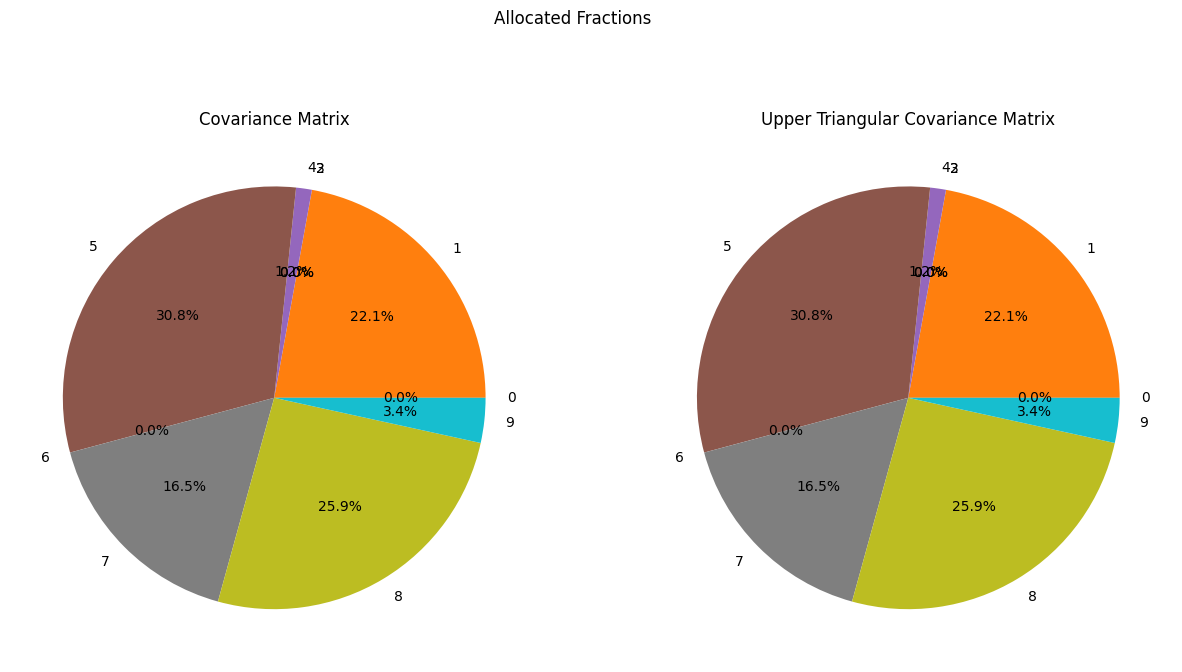

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Allocated Fractions')

ax1.title.set_text('Covariance Matrix')
ax2.title.set_text('Upper Triangular Covariance Matrix')


ax1.pie(list(optimal_portfolio_a.values()), labels=list(optimal_portfolio_a), autopct="%1.1f%%")
ax2.pie(list(optimal_portfolio_b.values()), labels=list(optimal_portfolio_b), autopct="%1.1f%%");

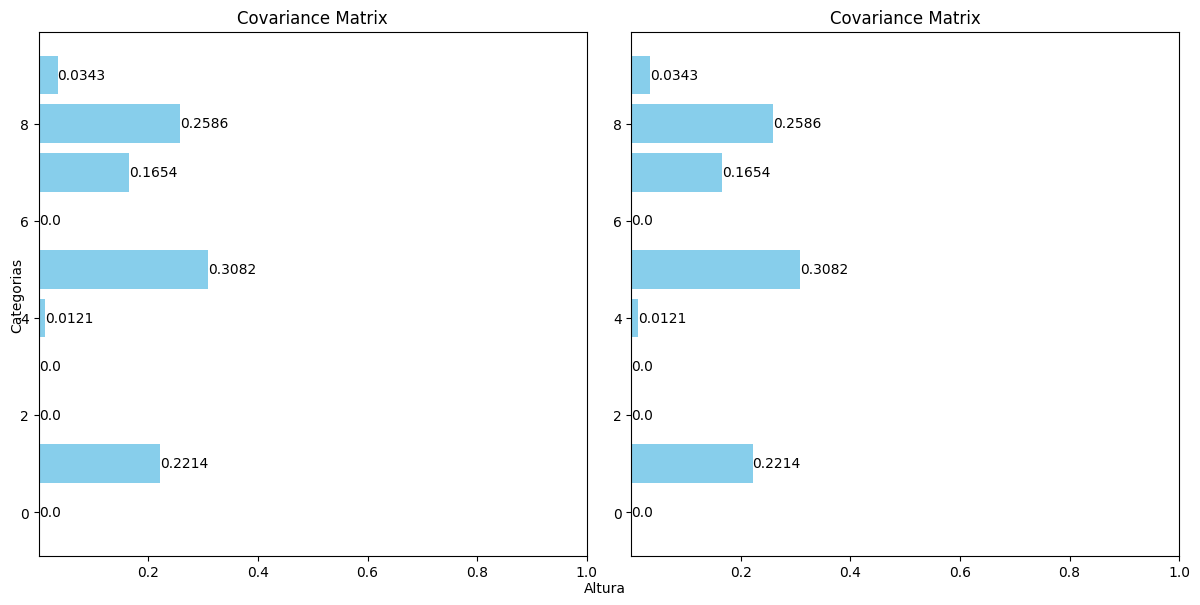

In [14]:
import matplotlib.pyplot as plt

def plot_bar_chart(data_list):
    num_categories = len(data_list[0])  # Assumindo que todos os dicionários têm o mesmo número de categorias
    
    fig, axs = plt.subplots(1, len(data_list), figsize=(12, 6))  # Criar subplots

    for i, data in enumerate(data_list):
        categories = list(data.keys())
        values = list(data.values())

        # Normalizar os valores para que a soma seja 1
        total = sum(values)
        normalized_values = [value / total for value in values]
        
        axs[i].barh(categories, normalized_values, color='skyblue')  # Usando plt.barh para barras horizontais

        # Adicionar os valores numéricos arredondados às barras com até 4 casas decimais
        for j, value in enumerate(normalized_values):
            rounded_value = round(value, 4)
            axs[i].text(value, j, str(rounded_value), ha='left', va='center')

        # Adicionar rótulos ao subplot
        # axs[i].set_xlabel('Altura')
        # axs[i].set_ylabel('Categorias')
        axs[i].set_title('Covariance Matrix')
        
        # Definir limites do eixo x
        axs[i].set_xlim(0.0000000001, 1)

        # axs[i].grid(True)

    # Adicionar rótulos gerais aos eixos X e Y
    fig.text(0.5, 0.004, 'Altura', ha='center')
    fig.text(0.004, 0.5, 'Categorias', va='center', rotation='vertical')

    plt.tight_layout()  # Ajustar o layout para evitar sobreposição
    plt.show()

# Exemplo de lista de dicionários de entrada
data_list = [optimal_portfolio_a,
             optimal_portfolio_b]

# Criar os diagramas de barras
plot_bar_chart(data_list)
